# 015. word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

<img src="https://i.imgur.com/fr5B4on.jpeg" width=500 />

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import re

### Toy 말뭉치

In [2]:
corpus = [
    "king is a very strong man",
    "queen is a wise and pretty woman",
    "boy is a young man",
    "girl is a young and pretty woman",
    "prince is young and will be a strong and wise king",
    "princess is a young woman and will be a pretty and wise queen",
    "man is strong",
    "woman is pretty",
    "prince is a boy and will be a king",
    "princess is a girl and will be a queen",
    "a king is powerful and strong",
    "a queen is beautiful and intelligent",
    "a boy is a youthful male",
    "a girl is a youthful and lovely female",
    "a prince is a young and smart future king",
    "a princess is a young and graceful future queen",
    "a king has power and strength",
    "a queen has wisdom and charm",
    "a prince will rule as a king one day",
    "a princess will become a queen in the future",
    "a king and a queen rule the kingdom",
    "a prince and a princess are part of the royal family",
    "a boy grows up to be a man",
    "a girl grows up to be a woman",
    "a strong man can become a king",
    "a wise woman can become a queen",
    "the king and queen live in castles",
    "prince and princess are members of the royal family",
    "a man and a woman can both be leaders",
    "a young boy dreams of becoming a king",
    "a young girl dreams of becoming a queen"
]

In [3]:
cleaned_corpus = []
for text in corpus:
    text = re.sub(r'[^a-zA-Z ]', '', text)   #영문
    cleaned_corpus.append(text.lower())

cleaned_corpus

['king is a very strong man',
 'queen is a wise and pretty woman',
 'boy is a young man',
 'girl is a young and pretty woman',
 'prince is young and will be a strong and wise king',
 'princess is a young woman and will be a pretty and wise queen',
 'man is strong',
 'woman is pretty',
 'prince is a boy and will be a king',
 'princess is a girl and will be a queen',
 'a king is powerful and strong',
 'a queen is beautiful and intelligent',
 'a boy is a youthful male',
 'a girl is a youthful and lovely female',
 'a prince is a young and smart future king',
 'a princess is a young and graceful future queen',
 'a king has power and strength',
 'a queen has wisdom and charm',
 'a prince will rule as a king one day',
 'a princess will become a queen in the future',
 'a king and a queen rule the kingdom',
 'a prince and a princess are part of the royal family',
 'a boy grows up to be a man',
 'a girl grows up to be a woman',
 'a strong man can become a king',
 'a wise woman can become a queen

In [4]:
stop_words = ['is', 'a', 'will', 'be', 'and', 'are', 'to', 'as', 'the', 'in', 'has', 'up', 'can', 'of']

cleaned = []

for text in cleaned_corpus:
    tmp = []
    for word in text.split():
        if word not in stop_words:
            tmp.append(word)
    cleaned.append(' '.join(tmp))

### vocaburary 모음 작성

In [5]:
words = []

for sentence in cleaned:
    for word in sentence.split(' '):
        words.append(word)

words = set(words)

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [6]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [7]:
word2index

{'wisdom': 0,
 'castles': 1,
 'very': 2,
 'grows': 3,
 'dreams': 4,
 'female': 5,
 'pretty': 6,
 'become': 7,
 'beautiful': 8,
 'wise': 9,
 'queen': 10,
 'live': 11,
 'man': 12,
 'family': 13,
 'smart': 14,
 'day': 15,
 'members': 16,
 'future': 17,
 'one': 18,
 'leaders': 19,
 'young': 20,
 'powerful': 21,
 'graceful': 22,
 'intelligent': 23,
 'kingdom': 24,
 'becoming': 25,
 'youthful': 26,
 'princess': 27,
 'charm': 28,
 'rule': 29,
 'part': 30,
 'girl': 31,
 'woman': 32,
 'boy': 33,
 'power': 34,
 'royal': 35,
 'both': 36,
 'male': 37,
 'king': 38,
 'prince': 39,
 'lovely': 40,
 'strength': 41,
 'strong': 42}

### skip-gram 으로 training data 생성

In [8]:
sentences = []
for sentence in cleaned:
    sentences.append(sentence.split())
sentences

[['king', 'very', 'strong', 'man'],
 ['queen', 'wise', 'pretty', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'pretty', 'woman'],
 ['prince', 'young', 'strong', 'wise', 'king'],
 ['princess', 'young', 'woman', 'pretty', 'wise', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen'],
 ['king', 'powerful', 'strong'],
 ['queen', 'beautiful', 'intelligent'],
 ['boy', 'youthful', 'male'],
 ['girl', 'youthful', 'lovely', 'female'],
 ['prince', 'young', 'smart', 'future', 'king'],
 ['princess', 'young', 'graceful', 'future', 'queen'],
 ['king', 'power', 'strength'],
 ['queen', 'wisdom', 'charm'],
 ['prince', 'rule', 'king', 'one', 'day'],
 ['princess', 'become', 'queen', 'future'],
 ['king', 'queen', 'rule', 'kingdom'],
 ['prince', 'princess', 'part', 'royal', 'family'],
 ['boy', 'grows', 'man'],
 ['girl', 'grows', 'woman'],
 ['strong', 'man', 'become', 'king'],
 ['wise', 'woman', 'become', 'queen'],
 ['king', 'queen', 'live', 

In [9]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [10]:
data[:10]

[['king', 'very'],
 ['king', 'strong'],
 ['very', 'king'],
 ['very', 'strong'],
 ['very', 'man'],
 ['strong', 'king'],
 ['strong', 'very'],
 ['strong', 'man'],
 ['man', 'very'],
 ['man', 'strong']]

In [11]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,king,very
1,king,strong
2,very,king
3,very,strong
4,very,man


### One hot encoding

In [12]:
from tensorflow.keras.utils import to_categorical

len(words)

43

### One hot encoding 된 train, label data

In [13]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [14]:
print(X[:3])
print(Y[:3])

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 

In [15]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [16]:
model = Sequential()
model.add(Dense(2, input_dim=len(words)))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.fit(X_train, Y_train, epochs=50, batch_size=3)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0847 - loss: 9.9142
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0624 - loss: 7.8697
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0806 - loss: 7.7357
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0887 - loss: 8.6907
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0756 - loss: 6.4148
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0741 - loss: 6.2599
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0764 - loss: 6.8770
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0786 - loss: 6.4672
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0900 - loss: 6.1752
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0646 - loss: 6.4103
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0972 - loss: 6.7491
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0641 - lo

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653 (2.55 KB)

 Trainable params: 217 (868.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 436 (1.71 KB)

In [19]:
model.layers[0].get_weights()

[array([[ 0.3426454 , -0.12048674],
        [ 0.33601514, -0.3465367 ],
        [-0.25069505, -0.10170235],
        [ 0.30423272,  0.00576353],
        [ 0.02256849,  0.0906139 ],
        [ 0.3130515 , -0.03324497],
        [-0.1807369 , -0.31080353],
        [-0.27574518, -0.281846  ],
        [-0.19732715,  0.35081208],
        [ 0.03672921, -0.16677207],
        [ 0.18811022, -0.04710628],
        [ 0.2371574 , -0.23026377],
        [-0.23629388,  0.21550134],
        [-0.11002609,  0.18419248],
        [ 0.011688  ,  0.01692701],
        [-0.01950687,  0.26587367],
        [-0.19007163, -0.06247851],
        [-0.25360036,  0.12532486],
        [ 0.3150175 ,  0.28215784],
        [-0.04434425, -0.06815046],
        [ 0.17867976,  0.16415894],
        [ 0.36321324, -0.01113969],
        [ 0.14025135, -0.28484416],
        [-0.12294213, -0.22640978],
        [ 0.05330032, -0.02107948],
        [ 0.36186337, -0.31717122],
        [ 0.37192947, -0.09562171],
        [ 0.19782186, -0.316

In [20]:
model.layers[0].get_weights()[1]

array([ 0.02988313, -0.00050911], dtype=float32)

In [21]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[ 0.37252855, -0.12099585],
       [ 0.36589825, -0.3470458 ],
       [-0.22081192, -0.10221147],
       [ 0.33411586,  0.00525441],
       [ 0.05245163,  0.09010479]], dtype=float32)

In [22]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = list(words)
w2v['x1'] *= 10
w2v['x2'] *= 10
w2v

,x1,x2,word
0,3.725286,-1.209959,wisdom
1,3.658983,-3.470458,castles
2,-2.208119,-1.022115,very
3,3.341159,0.052544,grows
4,0.524516,0.901048,dreams
5,3.429346,-0.337541,female
6,-1.508538,-3.113127,pretty
7,-2.458621,-2.823551,become
8,-1.674440,3.503030,beautiful
9,0.666123,-1.672812,wise


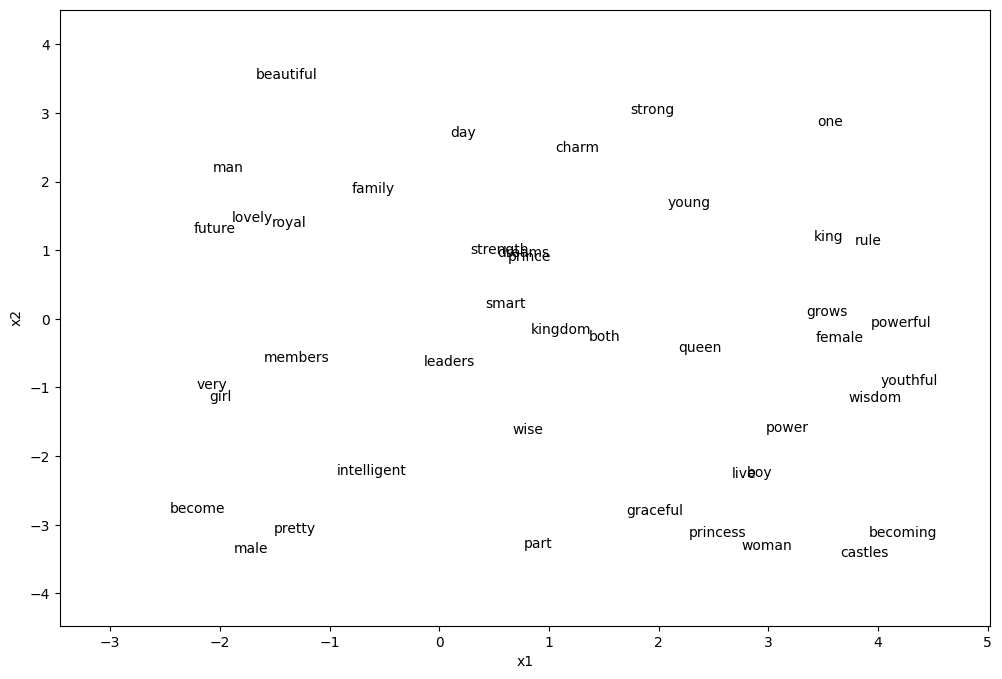

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()